In [381]:
import numpy as np
import tensorflow as tf
import gym
from gym import spaces
import copy

from stable_baselines.common.policies import *
from stable_baselines.common.vec_env import DummyVecEnv
from stable_baselines import *

In [382]:
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from celluloid import Camera

In [383]:
assert tf.version.VERSION[0] == '1'

## Area

In [397]:
class Area:
    def __init__(self, dummy_agent_count=False, size=100, threshold=0.6, border_width=2, border_val=-3):
        self.size = size
        self.threshold = threshold
        self.border_width = border_width
        self.border_val = border_val
        self.area = self.__generate_area()
        self.character_space = np.empty((test_area.area).shape, dtype=object) # 
        self.dummy_agent_count = dummy_agent_count
        if self.dummy_agent_count:
            dummy_agent_mask = np.random.random(size=[self.size, self.size]) < size/dummy_agent_count**2.
            low = self.border_width
            up = self.border_width + self.size
            self.character_space[low:up, low:up][dummy_agent_mask] = 1
        
            
    def reset(self):
        self.area = self.__generate_area()
        self.character_space = np.empty((test_area.area).shape, dtype=object) # 
    
    def visualize_character_space(self):
        return np.array(self.character_space != None, dtype=np.int)
    
    def get_random_pos(self):
        low = self.border_width
        high = self.size + self.border_width
        pos_arr = np.random.randint(low, high, size=(2,))
        return tuple(pos_arr)
    
    def area_update_pos(self, old_pos, new_pos, agent):
        self.character_space[old_pos] = None
        self.character_space[new_pos] = agent
        if self.dummy_agent_count:
            self.update_dummy_agents()
    
    def update_dummy_agents(self):
        pos = []
        for ri in range(len(self.character_space)):
            for ci in range(len(self.character_space)):
                if self.character_space[ri][ci] == 1:
                    self.character_space[ri][ci] = None
                    pos.append([ri,ci])
        for p in pos:
            axis = np.random.randint(2)
            move = np.random.randint(2)
            p[axis] += [-1,1][move]
            if p[0] > self.border_width and p[0] < self.size and p[1] > self.border_width and p[1] < self.size:
                self.character_space[p[0]][p[1]] = p
    
    def __generate_area(self):
        border_row = np.array([[self.border_val for i in range(self.size + 2*self.border_width)]])
        border = np.repeat(border_row, self.border_width, axis=0)
        init_area = border

        for i in range(self.size):
            row = (np.random.rand(self.size) > self.threshold).astype(int) * 3
            for i in range(self.border_width):
                row = np.insert(row, 0, self.border_val)
                row = np.append(row, self.border_val)
            init_area = np.concatenate((init_area, [row]))

        init_area = np.concatenate((init_area, border))

        return init_area

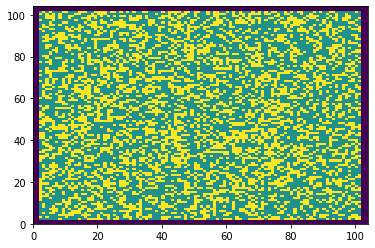

In [398]:
test_area = Area()

plt.pcolor(test_area.area)

## Agent

In [400]:
class Agent(gym.Env):
    
    def __init__(self, area):
        self.area = area
        self.reward_rangee = (0, 3)
        self.action_space = spaces.Discrete(6)
        self.observation_space = self.init_observation_space()
        self.position = self.area.get_random_pos()
        
    def reset(self, position=None, train=True):
        if not position:
            position = self.area.get_random_pos()
        self.fitness = 10
        self.update_position(position)
        self.reward_sum = 0
        if train:
            self.area.reset()
        
        return self._next_observation()
    
    def update_position(self, position):
        #print(self.area.visualize_character_space())
        self.area.area_update_pos(self.position, position, self)
        self.position = position
        
    def init_observation_space(self):
        map_ = [3 for i in range(25)] 
        actors = [2 for i in range(25)]
        nvec = map_ + actors
        return spaces.MultiDiscrete(nvec=nvec)
    
    def _next_observation(self):
        x, y = self.position
        visible_map = self.area.area[x-2:x+3, y-2:y+3]
        visible_actors = self.area.visualize_character_space()[x-2:x+3, y-2:y+3]
        visible = np.concatenate([visible_map.flatten(), visible_actors.flatten()])
        return visible
    
    def step(self, action, test=False):
        
        reward = 0
        x, y = self.position
        
        if action < 4:
            if action == 0:
                new_y = y-1 if y>self.area.border_width else y
                position = x, new_y
            if action == 1: 
                new_y = y+1 if y<self.area.size + self.area.border_width - 1 else y
                position = x, new_y
            if action == 2:
                new_x = x+1 if x<self.area.size + self.area.border_width - 1 else x
                position = new_x, y
            if action == 3:
                new_x = x-1 if x>self.area.border_width else x
                position = new_x, y
            if self.area.visualize_character_space()[position] == 0:
                self.update_position(position)
            x, y = self.position
            self.fitness -= 1
        elif action == 4:
            if self.area.area[x, y] == 3:
                self.reward_sum += 6
                self.fitness += 6
                reward = 6
                self.area.area[x, y] = 0
            else:
                self.fitness -= 1
        else: 
            if self.fitness >= 5 and np.sum(self.area.visualize_character_space()[x-1:x+2, y-1:y+2]) > 1:
                self.reward_sum += 16
                self.fitness -= 5
                reward = 16
                if test:
                    directions = np.array([[-1,0], [0,1],[1,0],[0,-1]])
                    direction_values = self.area.visualize_character_space()[x-1:x+2, y-1:y+2][[0,1,1,2],[1,0,2,1]] 
                    for mv,d in zip(directions, direction_values):
                        if d == 0:
                            x, y = np.array([x,y]) + mv
                            x_ok = x>self.area.border_width and x<self.area.size + self.area.border_width - 1
                            y_ok = y>self.area.border_width and y<self.area.size + self.area.border_width - 1
                            if(x_ok and y_ok):
                                spawn_new(x, y)
                                break
                    #spawn_new(x, y)
            else:
                self.fitness -= 1
                
        
        done = self.fitness <= 0
        
        obs = self._next_observation()
        
        return obs, reward, done, {}
    
    def render(self, mode='human', close=False):
        x, y = self.position
        print(self.__hash__(), ":  ", self.reward_sum)
        return x, y

## Model

In [401]:
agent_count = 200
area = Area(dummy_agent_count=agent_count)
model = A2C(MlpPolicy, Agent(area), verbose=0)
model.learn(total_timesteps=25000)

## Simulation

In [402]:
area = Area()
# env1 = Agent(area)
# env2 = Agent(area)
envs = [Agent(area) for i in range(agent_count)]
#envs = [env1, env2]
env_obs = {}

stored_maps = []
to_spawn = []

def spawn_new(x, y):
    to_spawn.append((x,y))

for env in envs:
    obs = env.reset(train=False)
    env_obs[env] = obs

for i in range(200):
    copied_map = np.copy(area.area)
    
    for x, y in to_spawn:
        new_env = Agent(area)
        obs = new_env.reset(position=(x, y), train=False)
        action, _states = model.predict(obs)
        obs, rewards, done, info = env.step(action, test=True)
        envs.append(new_env)
        env_obs[new_env] = obs
        print("New joined!")
        x, y = new_env.render()
    to_spawn.clear()
    
    for idx, env in enumerate(envs):
        obs = env_obs[env]
        action, _states = model.predict(obs)
        obs, rewards, done, info = env.step(action, test=True)
        env_obs[env] = obs
        x, y = env.render()
        copied_map[x,y] = -2
        if done:
            envs.pop(idx)
        
    stored_maps.append(copied_map)

-9223372029274905179 :   0
-9223372029261175734 :   6
7593600008 :   0
7593600071 :   0
-9223372029261175664 :   0
7593600155 :   0
-9223372029261175643 :   0
7593600176 :   6
-9223372029261175622 :   0
7593600197 :   6
-9223372029261175601 :   0
7593600218 :   6
-9223372029261175580 :   0
7593600239 :   0
-9223372029261175559 :   6
-9223372029263428022 :   6
-9223372029263428050 :   0
7591347790 :   6
-9223372029263428008 :   0
7591347811 :   0
-9223372029263427987 :   0
7591347832 :   6
-9223372029263427966 :   6
7591347853 :   6
-9223372029263427945 :   0
7591347874 :   0
-9223372029263427924 :   6
7591347895 :   0
-9223372029263427903 :   0
7591347916 :   6
-9223372029263427882 :   0
7591347937 :   6
-9223372029263427861 :   0
7591347958 :   6
-9223372029263428043 :   0
-9223372029263428085 :   6
7591347762 :   6
-9223372029263428071 :   6
7591776776 :   0
7591776797 :   0
-9223372029262999001 :   0
7591776818 :   0
-9223372029262998980 :   0
7591776839 :   0
-9223372029262998959 :

-9223372029262998812 :   12
7591777007 :   6
-9223372029262998791 :   6
7591776790 :   6
-9223372029271668827 :   12
7583107048 :   6
-9223372029271668771 :   12
7583107062 :   6
7583106831 :   6
-9223372029271668967 :   0
7583106852 :   12
-9223372029271668946 :   6
7583106873 :   0
-9223372029271668925 :   12
7583106894 :   22
-9223372029271668904 :   6
7583106915 :   12
-9223372029271668883 :   6
7583106936 :   6
-9223372029271668862 :   6
-9223372029271668834 :   6
-9223372029271668848 :   6
-9223372029271668813 :   6
-9223372029271668785 :   6
-9223372029271668820 :   6
-9223372029271668806 :   6
-9223372029271668988 :   12
-9223372029274895514 :   6
-9223372029274895570 :   12
-9223372029274895521 :   0
-9223372029274895528 :   6
7579880263 :   6
7579880249 :   6
-9223372029274895563 :   6
7579880228 :   6
7579880214 :   6
-9223372029274895605 :   6
-9223372029274895507 :   0
-9223372029274895486 :   6
7579880333 :   6
-9223372029274895465 :   6
7579880354 :   6
-9223372029274895

7591776797 :   6
-9223372029262999001 :   12
7591776818 :   12
-9223372029262998980 :   6
7591776839 :   12
-9223372029262998959 :   12
7591776860 :   12
-9223372029262998938 :   12
7591776881 :   6
-9223372029262998917 :   6
7591776902 :   12
-9223372029262998896 :   18
7591776923 :   6
-9223372029262998875 :   12
7591776944 :   6
-9223372029262998854 :   12
7591776965 :   12
-9223372029262998833 :   12
7591776986 :   18
-9223372029262998812 :   12
7591777007 :   12
-9223372029262998791 :   6
7591776790 :   12
-9223372029271668827 :   12
7583107048 :   6
-9223372029271668771 :   12
7583107062 :   12
7583106831 :   12
-9223372029271668967 :   6
7583106852 :   18
-9223372029271668946 :   12
7583106873 :   6
-9223372029271668925 :   18
7583106894 :   28
-9223372029271668904 :   6
7583106915 :   18
-9223372029271668883 :   6
7583106936 :   12
-9223372029271668862 :   12
-9223372029271668834 :   6
-9223372029271668848 :   12
-9223372029271668813 :   12
-9223372029271668785 :   12
-92233720

7591347762 :   18
-9223372029263428071 :   18
7591776776 :   12
7591776797 :   12
-9223372029262999001 :   12
7591776818 :   18
-9223372029262998980 :   6
7591776839 :   18
-9223372029262998959 :   18
7591776860 :   12
-9223372029262998938 :   18
7591776881 :   12
-9223372029262998917 :   6
7591776902 :   12
-9223372029262998896 :   18
7591776923 :   12
-9223372029262998875 :   12
7591776944 :   6
-9223372029262998854 :   18
7591776965 :   12
-9223372029262998833 :   12
7591776986 :   18
-9223372029262998812 :   18
7591777007 :   18
-9223372029262998791 :   6
7591776790 :   12
-9223372029271668827 :   12
7583107048 :   12
-9223372029271668771 :   18
7583107062 :   12
7583106831 :   12
-9223372029271668967 :   6
7583106852 :   24
-9223372029271668946 :   12
7583106873 :   12
-9223372029271668925 :   24
7583106894 :   28
-9223372029271668904 :   6
7583106915 :   24
-9223372029271668883 :   6
7583106936 :   18
-9223372029271668862 :   12
-9223372029271668834 :   12
-9223372029271668848 : 

7591776776 :   18
7591776797 :   18
-9223372029262999001 :   18
7591776818 :   18
-9223372029262998980 :   6
7591776839 :   24
-9223372029262998959 :   18
7591776860 :   12
-9223372029262998938 :   18
7591776881 :   12
-9223372029262998917 :   12
7591776902 :   12
-9223372029262998896 :   18
7591776923 :   18
-9223372029262998875 :   12
7591776944 :   6
-9223372029262998854 :   24
7591776965 :   18
-9223372029262998833 :   18
7591776986 :   24
-9223372029262998812 :   18
7591777007 :   18
-9223372029262998791 :   6
7591776790 :   12
-9223372029271668827 :   12
7583107048 :   18
-9223372029271668771 :   24
7583107062 :   12
7583106831 :   18
-9223372029271668967 :   6
7583106852 :   24
-9223372029271668946 :   18
7583106873 :   12
-9223372029271668925 :   30
7583106894 :   28
-9223372029271668904 :   6
7583106915 :   24
-9223372029271668883 :   12
7583106936 :   18
-9223372029271668862 :   12
-9223372029271668834 :   18
-9223372029271668848 :   18
-9223372029271668813 :   18
-9223372029

7593600197 :   18
-9223372029261175601 :   18
7593600218 :   24
-9223372029261175580 :   24
7593600239 :   6
-9223372029261175559 :   12
-9223372029263428022 :   24
-9223372029263428050 :   6
7591347790 :   30
-9223372029263428008 :   12
7591347811 :   24
-9223372029263427987 :   30
7591347832 :   30
-9223372029263427966 :   30
7591347853 :   24
-9223372029263427945 :   12
7591347874 :   24
-9223372029263427924 :   24
7591347895 :   12
-9223372029263427903 :   18
7591347916 :   30
-9223372029263427882 :   24
7591347937 :   18
-9223372029263427861 :   6
7591347958 :   30
-9223372029263428043 :   18
-9223372029263428085 :   12
7591347762 :   30
-9223372029263428071 :   24
7591776776 :   18
7591776797 :   24
-9223372029262999001 :   18
7591776818 :   24
-9223372029262998980 :   6
7591776839 :   30
-9223372029262998959 :   24
7591776860 :   18
-9223372029262998938 :   18
7591776881 :   12
-9223372029262998917 :   18
7591776902 :   18
-9223372029262998896 :   24
7591776923 :   24
-922337202

7591777007 :   18
-9223372029262998791 :   6
7591776790 :   12
-9223372029271668827 :   18
7583107048 :   24
-9223372029271668771 :   36
7583107062 :   24
7583106831 :   24
-9223372029271668967 :   12
7583106852 :   36
-9223372029271668946 :   30
7583106873 :   24
-9223372029271668925 :   30
7583106894 :   28
-9223372029271668904 :   12
7583106915 :   36
-9223372029271668883 :   18
7583106936 :   24
-9223372029271668862 :   12
-9223372029271668834 :   24
-9223372029271668848 :   30
-9223372029271668813 :   30
-9223372029271668785 :   24
-9223372029271668820 :   18
-9223372029271668806 :   18
-9223372029271668988 :   18
-9223372029274895514 :   24
-9223372029274895570 :   30
-9223372029274895521 :   30
-9223372029274895528 :   30
7579880263 :   36
7579880249 :   36
-9223372029274895563 :   30
7579880228 :   18
7579880214 :   30
-9223372029274895605 :   36
-9223372029274895507 :   24
-9223372029274895486 :   12
7579880333 :   30
-9223372029274895465 :   30
7579880354 :   24
-922337202927

7579880396 :   30
-9223372029274895402 :   12
-9223372029274895388 :   42
7579880431 :   18
7579880312 :   24
-9223372029274895381 :   24
-9223372029274924579 :   24
-9223372029274922962 :   30
-9223372029274922829 :   36
7579857209 :   18
-9223372029271112227 :   12
7589930209 :   24
7589930020 :   30
7589930230 :   30
-9223372029274914251 :   30
-9223372029274919406 :   24
-9223372029262881378 :   24
-9223372029262881315 :   24
-9223372029262881364 :   24
-9223372029262881413 :   18
7591894343 :   24
7591894455 :   18
-9223372029262881427 :   24
-9223372029262881371 :   30
-9223372029262881294 :   30
-9223372029262881406 :   30
-9223372029262881336 :   24
7578350961 :   18
-9223372029264839196 :   18
-9223372029274918228 :   36
7579857535 :   24
7591895672 :   36
7591895644 :   36
-9223372029262880210 :   24
-9223372029262880245 :   18
7591895623 :   36
-9223372029262880252 :   30
-9223372029262880105 :   36
7591895658 :   18
-9223372029262880238 :   36
7579853239 :   30
-92233720292

7583714813 :   12
7591678128 :   36
-9223372029263097845 :   18
7591677974 :   30
-9223372029263097824 :   24
7591677995 :   36
-9223372029263097803 :   24
7591678016 :   24
-9223372029263097782 :   36
7591678037 :   36
-9223372029263097761 :   24
7591678058 :   30
-9223372029263097740 :   42
7591678079 :   18
7591678093 :   24
-9223372029263097705 :   18
-9223372029263097719 :   30
7591678135 :   24
-9223372029263097663 :   36
7591678156 :   30
-9223372029263097642 :   30
7591678177 :   18
7591678198 :   24
7591678191 :   24
-9223372029263097684 :   30
-9223372029263220213 :   24
7591555606 :   30
-9223372029263220192 :   24
7591555627 :   36
-9223372029263220171 :   30
7591555648 :   48
-9223372029263220150 :   36
7591555669 :   24
-9223372029263220129 :   30
7591555690 :   36
7591555718 :   36
7591555704 :   12
7591555725 :   24
7591555746 :   18
-9223372029263220052 :   24
7591555767 :   36
-9223372029263220031 :   34
7591555788 :   30
-9223372029263220010 :   36
7591555809 :   42


-9223372029261175734 :   30
7593600008 :   30
7593600071 :   24
-9223372029261175664 :   42
7593600155 :   12
-9223372029261175643 :   12
7593600176 :   48
-9223372029261175622 :   18
7593600197 :   24
-9223372029261175601 :   42
7593600218 :   30
-9223372029261175580 :   36
7593600239 :   18
-9223372029261175559 :   12
-9223372029263428022 :   42
7591347790 :   42
-9223372029263428008 :   30
7591347811 :   36
-9223372029263427987 :   36
7591347832 :   48
-9223372029263427966 :   36
7591347853 :   36
-9223372029263427945 :   24
7591347874 :   30
-9223372029263427924 :   36
7591347895 :   12
-9223372029263427903 :   24
7591347916 :   36
-9223372029263427882 :   30
7591347937 :   36
-9223372029263427861 :   18
7591347958 :   42
-9223372029263428043 :   42
-9223372029263428085 :   30
7591347762 :   48
-9223372029263428071 :   42
7591776776 :   36
7591776797 :   36
-9223372029262999001 :   36
7591776818 :   48
7591776839 :   36
-9223372029262998959 :   42
7591776860 :   24
-922337202926299

7591678079 :   18
7591678093 :   24
-9223372029263097705 :   24
-9223372029263097719 :   42
7591678135 :   24
-9223372029263097663 :   42
7591678156 :   42
-9223372029263097642 :   42
7591678177 :   24
7591678198 :   24
7591678191 :   46
-9223372029263097684 :   36
-9223372029263220213 :   30
7591555606 :   36
-9223372029263220192 :   36
7591555627 :   36
-9223372029263220171 :   36
7591555648 :   54
-9223372029263220150 :   48
7591555669 :   30
-9223372029263220129 :   30
7591555690 :   48
7591555718 :   42
7591555704 :   18
7591555725 :   24
7591555746 :   24
-9223372029263220052 :   24
7591555767 :   42
-9223372029263220031 :   34
7591555788 :   30
-9223372029263220010 :   36
7591555809 :   54
-9223372029263219989 :   36
7591555830 :   48
-9223372029263220080 :   48
-9223372029263197703 :   36
7591577976 :   0
-9223372029263175648 :   0
-9223372029274905179 :   30
-9223372029261175734 :   30
7593600008 :   36
7593600071 :   24
-9223372029261175664 :   48
7593600155 :   18
-922337202

7591555809 :   60
-9223372029263219989 :   36
7591555830 :   48
-9223372029263220080 :   48
-9223372029263197703 :   42
7591577976 :   0
-9223372029263197717 :   0
New joined!
7591577955 :   0
-9223372029274905179 :   36
-9223372029261175734 :   30
7593600008 :   42
7593600071 :   24
-9223372029261175664 :   48
7593600155 :   18
-9223372029261175643 :   18
7593600176 :   60
-9223372029261175622 :   24
7593600197 :   36
-9223372029261175601 :   54
7593600218 :   30
-9223372029261175580 :   42
7593600239 :   18
-9223372029261175559 :   12
7591347790 :   48
-9223372029263428008 :   36
7591347811 :   36
-9223372029263427987 :   36
7591347832 :   60
-9223372029263427966 :   42
7591347853 :   42
-9223372029263427945 :   30
7591347874 :   42
-9223372029263427924 :   42
7591347895 :   18
-9223372029263427903 :   24
7591347916 :   36
-9223372029263427882 :   42
7591347937 :   36
-9223372029263427861 :   18
7591347958 :   42
-9223372029263428043 :   42
-9223372029263428085 :   30
7591347762 :   

-9223372029263097761 :   24
7591678058 :   36
-9223372029263097740 :   42
7591678079 :   18
7591678093 :   24
-9223372029263097705 :   36
-9223372029263097719 :   48
7591678135 :   30
-9223372029263097663 :   42
7591678156 :   48
-9223372029263097642 :   48
7591678177 :   36
7591678198 :   24
7591678191 :   46
-9223372029263097684 :   48
-9223372029263220213 :   42
7591555606 :   48
-9223372029263220192 :   48
7591555627 :   48
-9223372029263220171 :   42
7591555648 :   54
-9223372029263220150 :   48
7591555669 :   36
-9223372029263220129 :   36
7591555690 :   48
7591555718 :   48
7591555704 :   24
7591555725 :   24
7591555746 :   24
-9223372029263220052 :   30
7591555767 :   54
-9223372029263220031 :   40
7591555788 :   30
-9223372029263220010 :   42
7591555809 :   60
-9223372029263219989 :   42
7591555830 :   54
-9223372029263220080 :   54
-9223372029263197703 :   42
-9223372029263175648 :   0
-9223372029263197717 :   0
7591577955 :   0
-9223372029274905179 :   42
-922337202926117573

7591894343 :   48
7591894455 :   30
-9223372029262881427 :   24
-9223372029262881371 :   48
-9223372029262881294 :   36
-9223372029262881406 :   48
-9223372029262881336 :   36
7578350961 :   24
-9223372029264839196 :   24
-9223372029274918228 :   60
7579857535 :   36
7591895672 :   48
7591895644 :   66
-9223372029262880210 :   42
-9223372029262880245 :   30
7591895623 :   54
-9223372029262880252 :   42
-9223372029262880105 :   48
7591895658 :   30
-9223372029262880238 :   42
7579853239 :   42
-9223372029271183416 :   66
7583592347 :   30
7579853467 :   42
7579853439 :   42
7579850423 :   46
7583714708 :   48
-9223372029271061083 :   60
-9223372029271061139 :   30
7583714813 :   24
7591678128 :   60
-9223372029263097845 :   24
7591677974 :   42
-9223372029263097824 :   54
7591677995 :   54
-9223372029263097803 :   48
7591678016 :   24
-9223372029263097782 :   54
7591678037 :   54
-9223372029263097761 :   24
7591678058 :   36
-9223372029263097740 :   42
7591678079 :   18
7591678093 :   2

-9223372029274895507 :   48
-9223372029274895486 :   18
7579880333 :   60
-9223372029274895465 :   52
7579880354 :   60
-9223372029274895444 :   60
7579880375 :   60
-9223372029274895423 :   54
7579880396 :   54
-9223372029274895388 :   72
7579880431 :   36
7579880312 :   36
-9223372029274895381 :   42
-9223372029274924579 :   60
-9223372029274922962 :   48
-9223372029274922829 :   72
7579857209 :   36
7589930209 :   36
7589930020 :   30
7589930230 :   48
-9223372029274914251 :   54
-9223372029274919406 :   24
-9223372029262881378 :   48
-9223372029262881315 :   42
-9223372029262881364 :   42
-9223372029262881413 :   42
7591894343 :   48
7591894455 :   30
-9223372029262881427 :   24
-9223372029262881371 :   48
-9223372029262881294 :   36
-9223372029262881406 :   48
-9223372029262881336 :   42
7578350961 :   24
-9223372029264839196 :   24
-9223372029274918228 :   66
7579857535 :   42
7591895672 :   54
7591895644 :   66
-9223372029262880210 :   42
-9223372029262880245 :   30
7591895623 :

7583106915 :   66
-9223372029271668883 :   42
7583106936 :   36
-9223372029271668862 :   42
-9223372029271668834 :   42
-9223372029271668848 :   54
-9223372029271668813 :   60
-9223372029271668785 :   36
-9223372029271668820 :   48
-9223372029271668806 :   42
-9223372029271668988 :   24
-9223372029274895514 :   42
-9223372029274895570 :   66
-9223372029274895521 :   60
-9223372029274895528 :   60
7579880263 :   60
7579880249 :   84
-9223372029274895563 :   48
7579880228 :   18
-9223372029274895605 :   36
-9223372029274895507 :   54
-9223372029274895486 :   18
-9223372029274895465 :   52
7579880354 :   66
-9223372029274895444 :   66
7579880375 :   60
-9223372029274895423 :   60
7579880396 :   54
-9223372029274895388 :   72
7579880431 :   36
7579880312 :   42
-9223372029274895381 :   42
-9223372029274924579 :   60
-9223372029274922962 :   54
-9223372029274922829 :   78
7579857209 :   36
7589930209 :   36
7589930020 :   30
7589930230 :   48
-9223372029274914251 :   54
-9223372029274919406

-9223372029262998959 :   60
7591776860 :   36
-9223372029262998938 :   24
7591776881 :   36
-9223372029262998917 :   48
7591776902 :   60
-9223372029262998896 :   36
7591776923 :   66
-9223372029262998875 :   72
7591776944 :   54
-9223372029262998854 :   66
7591776965 :   48
-9223372029262998833 :   36
7591776986 :   42
-9223372029262998812 :   72
7591777007 :   54
7591776790 :   54
-9223372029271668827 :   24
7583107048 :   60
-9223372029271668771 :   66
7583107062 :   30
7583106831 :   60
-9223372029271668967 :   48
7583106852 :   72
-9223372029271668946 :   54
7583106873 :   78
-9223372029271668925 :   48
7583106894 :   58
-9223372029271668904 :   42
7583106915 :   66
-9223372029271668883 :   48
7583106936 :   36
-9223372029271668862 :   48
-9223372029271668834 :   48
-9223372029271668848 :   54
-9223372029271668813 :   66
-9223372029271668785 :   36
-9223372029271668820 :   48
-9223372029271668806 :   48
-9223372029271668988 :   24
-9223372029274895514 :   42
-9223372029274895570 :

-9223372029261175580 :   54
7593600239 :   24
-9223372029263428022 :   66
7591347790 :   48
-9223372029263428008 :   54
7591347811 :   36
-9223372029263427987 :   60
7591347832 :   72
-9223372029263427966 :   42
7591347853 :   42
-9223372029263427945 :   42
7591347874 :   72
-9223372029263427924 :   66
-9223372029263427903 :   24
7591347916 :   36
-9223372029263427882 :   72
7591347937 :   36
7591347958 :   54
-9223372029263428043 :   66
-9223372029263428085 :   46
7591347762 :   72
-9223372029263428071 :   42
7591776776 :   48
7591776797 :   48
-9223372029262999001 :   60
7591776818 :   60
7591776839 :   36
-9223372029262998959 :   66
7591776860 :   42
-9223372029262998938 :   30
7591776881 :   36
-9223372029262998917 :   48
7591776902 :   60
-9223372029262998896 :   36
7591776923 :   72
-9223372029262998875 :   78
7591776944 :   54
-9223372029262998854 :   72
7591776965 :   48
-9223372029262998833 :   42
7591776986 :   48
-9223372029262998812 :   72
7591777007 :   54
7591776790 :   6

-9223372029263219989 :   66
7591555830 :   54
-9223372029263220080 :   78
-9223372029263197703 :   48
7591577955 :   24
-9223372029263197822 :   0
7591600150 :   0
-9223372029263175557 :   0
-9223372029274905179 :   60
-9223372029261175734 :   30
7593600008 :   54
7593600071 :   48
-9223372029261175664 :   72
-9223372029261175643 :   24
7593600176 :   94
-9223372029261175622 :   42
7593600197 :   48
-9223372029261175601 :   78
7593600218 :   30
-9223372029261175580 :   54
7593600239 :   24
-9223372029263428022 :   72
7591347790 :   48
-9223372029263428008 :   60
7591347811 :   36
-9223372029263427987 :   60
7591347832 :   78
-9223372029263427966 :   42
7591347853 :   42
-9223372029263427945 :   42
7591347874 :   78
-9223372029263427924 :   66
-9223372029263427903 :   24
7591347916 :   36
-9223372029263427882 :   72
7591347937 :   36
7591347958 :   60
-9223372029263428043 :   66
-9223372029263428085 :   46
7591347762 :   78
-9223372029263428071 :   42
7591776776 :   48
7591776797 :   48

-9223372029263097705 :   66
-9223372029263097719 :   60
7591678135 :   48
-9223372029263097663 :   48
7591678156 :   54
-9223372029263097642 :   66
7591678177 :   54
7591678198 :   30
7591678191 :   46
-9223372029263097684 :   60
-9223372029263220213 :   72
7591555606 :   66
-9223372029263220192 :   72
7591555627 :   72
-9223372029263220171 :   78
7591555648 :   66
-9223372029263220150 :   48
7591555669 :   54
-9223372029263220129 :   54
7591555690 :   72
7591555718 :   60
7591555704 :   42
7591555725 :   48
7591555746 :   42
-9223372029263220052 :   60
7591555767 :   72
-9223372029263220031 :   52
7591555788 :   48
-9223372029263220010 :   48
7591555809 :   72
-9223372029263219989 :   66
7591555830 :   54
-9223372029263220080 :   84
-9223372029263197703 :   54
7591577955 :   30
-9223372029263197822 :   0
7591600150 :   0
-9223372029263175557 :   0
-9223372029263175599 :   0
-9223372029274905179 :   66
-9223372029261175734 :   30
7593600008 :   54
7593600071 :   54
-9223372029261175664

7579850423 :   58
7583714708 :   66
-9223372029271061083 :   72
-9223372029271061139 :   42
7583714813 :   42
7591678128 :   78
-9223372029263097845 :   36
7591677974 :   42
-9223372029263097824 :   60
7591677995 :   60
-9223372029263097803 :   54
-9223372029263097782 :   72
7591678037 :   72
7591678058 :   48
-9223372029263097740 :   42
7591678093 :   30
-9223372029263097705 :   66
-9223372029263097719 :   60
7591678135 :   54
-9223372029263097663 :   54
7591678156 :   54
-9223372029263097642 :   66
7591678177 :   60
7591678198 :   30
7591678191 :   46
-9223372029263097684 :   60
-9223372029263220213 :   78
7591555606 :   66
-9223372029263220192 :   78
7591555627 :   72
-9223372029263220171 :   84
7591555648 :   66
-9223372029263220150 :   48
7591555669 :   60
-9223372029263220129 :   60
7591555690 :   72
7591555718 :   60
7591555704 :   42
7591555725 :   48
7591555746 :   42
-9223372029263220052 :   60
7591555767 :   78
-9223372029263220031 :   52
7591555788 :   48
-92233720292632200

-9223372029264839196 :   52
-9223372029274918228 :   78
7579857535 :   66
7591895672 :   72
7591895644 :   96
-9223372029262880210 :   60
-9223372029262880245 :   66
7591895623 :   60
-9223372029262880252 :   42
-9223372029262880105 :   60
7591895658 :   54
-9223372029262880238 :   66
7579853239 :   42
-9223372029271183416 :   78
7583592347 :   36
7579853467 :   78
7579853439 :   78
7579850423 :   58
7583714708 :   72
-9223372029271061083 :   72
-9223372029271061139 :   42
7583714813 :   48
7591678128 :   84
-9223372029263097845 :   36
7591677974 :   42
-9223372029263097824 :   66
7591677995 :   66
-9223372029263097803 :   54
-9223372029263097782 :   78
7591678037 :   72
7591678058 :   48
-9223372029263097740 :   42
7591678093 :   30
-9223372029263097705 :   72
-9223372029263097719 :   60
7591678135 :   60
-9223372029263097663 :   60
7591678156 :   54
-9223372029263097642 :   72
7591678177 :   66
7591678198 :   30
-9223372029263097684 :   60
-9223372029263220213 :   78
7591555606 :   6

7589930209 :   36
7589930020 :   48
7589930230 :   60
-9223372029274914251 :   60
-9223372029274919406 :   36
-9223372029262881378 :   66
-9223372029262881315 :   84
-9223372029262881364 :   54
-9223372029262881413 :   60
7591894343 :   66
7591894455 :   30
-9223372029262881371 :   60
-9223372029262881294 :   48
-9223372029262881406 :   66
-9223372029262881336 :   48
7578350961 :   30
-9223372029264839196 :   52
-9223372029274918228 :   78
7579857535 :   72
7591895672 :   72
7591895644 :   96
-9223372029262880210 :   60
-9223372029262880245 :   66
7591895623 :   60
-9223372029262880252 :   42
-9223372029262880105 :   66
7591895658 :   54
-9223372029262880238 :   66
7579853239 :   42
-9223372029271183416 :   78
7583592347 :   36
7579853467 :   84
7579853439 :   78
7579850423 :   58
7583714708 :   72
-9223372029271061083 :   72
-9223372029271061139 :   42
7583714813 :   54
7591678128 :   90
-9223372029263097845 :   36
7591677974 :   42
-9223372029263097824 :   66
7591677995 :   72
-92233

7579880431 :   52
7579880312 :   66
-9223372029274895381 :   60
-9223372029274924579 :   96
-9223372029274922962 :   84
-9223372029274922829 :   114
7579857209 :   48
7589930209 :   36
7589930020 :   48
7589930230 :   60
-9223372029274914251 :   60
-9223372029274919406 :   42
-9223372029262881378 :   72
-9223372029262881315 :   84
-9223372029262881364 :   54
-9223372029262881413 :   60
7591894343 :   66
-9223372029262881371 :   60
-9223372029262881294 :   48
-9223372029262881406 :   66
-9223372029262881336 :   48
-9223372029264839196 :   52
-9223372029274918228 :   78
7579857535 :   72
7591895672 :   78
7591895644 :   102
-9223372029262880210 :   60
-9223372029262880245 :   66
7591895623 :   60
-9223372029262880252 :   42
-9223372029262880105 :   66
7591895658 :   60
-9223372029262880238 :   72
7579853239 :   42
-9223372029271183416 :   78
7583592347 :   36
7579853467 :   90
7579853439 :   84
7579850423 :   58
7583714708 :   72
-9223372029271061083 :   72
-9223372029271061139 :   42
75

7589930209 :   36
7589930020 :   48
7589930230 :   66
-9223372029274914251 :   60
-9223372029274919406 :   42
-9223372029262881378 :   78
-9223372029262881315 :   90
-9223372029262881364 :   54
-9223372029262881413 :   60
7591894343 :   66
-9223372029262881371 :   60
-9223372029262881294 :   54
-9223372029262881406 :   66
-9223372029262881336 :   48
-9223372029264839196 :   58
-9223372029274918228 :   78
7579857535 :   72
7591895672 :   84
7591895644 :   108
-9223372029262880210 :   60
-9223372029262880245 :   66
7591895623 :   60
-9223372029262880252 :   42
-9223372029262880105 :   66
7591895658 :   60
-9223372029262880238 :   72
7579853239 :   42
-9223372029271183416 :   78
7583592347 :   36
7579853467 :   90
7579853439 :   84
7579850423 :   58
7583714708 :   72
-9223372029271061083 :   72
-9223372029271061139 :   42
7583714813 :   54
7591678128 :   90
-9223372029263097845 :   36
7591677974 :   42
-9223372029263097824 :   78
7591677995 :   78
-9223372029263097803 :   60
-922337202926

-9223372029264839196 :   64
-9223372029274918228 :   78
7579857535 :   72
7591895672 :   90
7591895644 :   108
-9223372029262880210 :   60
-9223372029262880245 :   66
7591895623 :   60
-9223372029262880252 :   42
-9223372029262880105 :   66
7591895658 :   60
-9223372029262880238 :   72
7579853239 :   42
-9223372029271183416 :   78
7583592347 :   36
7579853467 :   90
7579853439 :   84
7579850423 :   58
7583714708 :   72
-9223372029271061083 :   72
-9223372029271061139 :   42
7583714813 :   54
7591678128 :   90
-9223372029263097845 :   36
7591677974 :   42
-9223372029263097824 :   78
7591677995 :   84
-9223372029263097803 :   60
-9223372029263097782 :   90
7591678037 :   84
7591678058 :   48
-9223372029263097740 :   42
-9223372029263097705 :   84
-9223372029263097719 :   60
7591678135 :   60
-9223372029263097663 :   60
7591678156 :   54
-9223372029263097642 :   84
7591678177 :   78
-9223372029263097684 :   72
-9223372029263220213 :   78
7591555606 :   66
-9223372029263220192 :   90
75915

-9223372029271183416 :   78
7583592347 :   36
7579853439 :   84
7579850423 :   58
7583714708 :   72
-9223372029271061083 :   72
-9223372029271061139 :   42
7583714813 :   54
7591678128 :   90
-9223372029263097845 :   42
7591677974 :   48
-9223372029263097824 :   84
7591677995 :   84
-9223372029263097803 :   76
-9223372029263097782 :   90
7591678037 :   84
7591678058 :   54
-9223372029263097740 :   42
-9223372029263097705 :   84
-9223372029263097719 :   60
7591678135 :   66
-9223372029263097663 :   60
7591678156 :   60
-9223372029263097642 :   84
7591678177 :   78
-9223372029263097684 :   72
-9223372029263220213 :   84
7591555606 :   66
-9223372029263220192 :   96
7591555627 :   84
-9223372029263220171 :   114
7591555648 :   90
-9223372029263220150 :   48
7591555669 :   78
-9223372029263220129 :   66
7591555690 :   78
7591555718 :   60
7591555704 :   42
7591555725 :   66
7591555746 :   48
-9223372029263220052 :   84
7591555767 :   90
-9223372029263220031 :   58
7591555788 :   48
-922337

7591555606 :   66
-9223372029263220192 :   96
7591555627 :   90
-9223372029263220171 :   120
7591555648 :   96
-9223372029263220150 :   48
7591555669 :   78
-9223372029263220129 :   66
7591555690 :   78
7591555718 :   60
7591555704 :   42
7591555725 :   72
7591555746 :   48
-9223372029263220052 :   84
7591555767 :   90
-9223372029263220031 :   58
7591555788 :   48
-9223372029263220010 :   54
7591555809 :   72
-9223372029263219989 :   66
7591555830 :   66
-9223372029263220080 :   126
-9223372029263197703 :   54
7591577955 :   42
-9223372029263175599 :   12
-9223372029263175613 :   12
-9223372029263197920 :   0
-9223372029274905179 :   78
7593600008 :   60
7593600071 :   60
-9223372029261175664 :   78
7593600176 :   94
-9223372029261175622 :   48
7593600197 :   60
-9223372029261175601 :   108
-9223372029261175580 :   54
-9223372029263428022 :   108
7591347790 :   54
-9223372029263428008 :   90
-9223372029263427987 :   60
7591347832 :   108
-9223372029263427966 :   54
7591347853 :   60
-9

7593600008 :   60
7593600071 :   60
-9223372029261175664 :   78
7593600176 :   94
-9223372029261175622 :   48
7593600197 :   60
-9223372029261175601 :   108
-9223372029261175580 :   54
-9223372029263428022 :   114
7591347790 :   60
-9223372029263428008 :   96
-9223372029263427987 :   60
7591347832 :   114
-9223372029263427966 :   54
7591347853 :   60
-9223372029263427945 :   60
7591347874 :   102
-9223372029263427924 :   96
-9223372029263427882 :   84
7591347958 :   72
-9223372029263428043 :   96
7591347762 :   114
-9223372029263428071 :   42
7591776776 :   54
7591776797 :   48
-9223372029262999001 :   108
7591776818 :   88
-9223372029262998959 :   108
7591776860 :   66
-9223372029262998917 :   48
7591776902 :   90
7591776923 :   96
-9223372029262998875 :   102
7591776944 :   96
-9223372029262998854 :   108
7591776965 :   60
-9223372029262998833 :   60
7591776986 :   60
-9223372029262998812 :   84
7591777007 :   60
7591776790 :   90
7583107048 :   102
-9223372029271668771 :   108
75831

7591776902 :   90
7591776923 :   96
-9223372029262998875 :   102
7591776944 :   102
-9223372029262998854 :   114
7591776965 :   66
-9223372029262998833 :   60
7591776986 :   60
-9223372029262998812 :   84
7591777007 :   60
7591776790 :   90
7583107048 :   102
-9223372029271668771 :   108
7583107062 :   72
7583106831 :   96
-9223372029271668967 :   78
7583106852 :   84
-9223372029271668946 :   84
7583106873 :   108
-9223372029271668925 :   78
7583106894 :   76
-9223372029271668904 :   42
-9223372029271668883 :   78
7583106936 :   60
-9223372029271668862 :   54
-9223372029271668834 :   78
-9223372029271668848 :   84
-9223372029271668813 :   84
-9223372029271668785 :   42
-9223372029271668806 :   114
-9223372029271668988 :   42
-9223372029274895570 :   78
-9223372029274895521 :   120
-9223372029274895528 :   78
7579880263 :   90
7579880249 :   108
-9223372029274895563 :   78
7579880214 :   96
-9223372029274895605 :   60
-9223372029274895507 :   84
7579880333 :   90
-9223372029274895465 : 

7579880312 :   72
-9223372029274895381 :   72
-9223372029274924579 :   132
-9223372029274922962 :   96
-9223372029274922829 :   138
7579857209 :   72
7589930020 :   64
7589930230 :   66
-9223372029274914251 :   60
-9223372029262881378 :   90
-9223372029262881315 :   120
-9223372029262881364 :   78
-9223372029262881413 :   84
7591894343 :   72
-9223372029262881371 :   60
-9223372029262881294 :   72
-9223372029262881406 :   84
-9223372029262881336 :   60
-9223372029264839196 :   64
-9223372029274918228 :   84
7579857535 :   72
7591895672 :   108
7591895644 :   120
-9223372029262880210 :   66
-9223372029262880245 :   66
7591895623 :   60
-9223372029262880105 :   66
7591895658 :   60
-9223372029262880238 :   84
-9223372029271183416 :   78
7579853467 :   90
7579853439 :   84
7579850423 :   64
7583714708 :   84
-9223372029271061083 :   72
7583714813 :   54
7591678128 :   90
-9223372029263097845 :   60
7591677974 :   54
-9223372029263097824 :   108
7591677995 :   102
-9223372029263097803 :   

7591678037 :   96
7591678058 :   72
-9223372029263097705 :   96
-9223372029263097719 :   60
7591678135 :   84
-9223372029263097663 :   72
7591678156 :   66
-9223372029263097642 :   96
7591678177 :   84
-9223372029263097684 :   72
-9223372029263220213 :   96
7591555606 :   66
-9223372029263220192 :   114
7591555627 :   102
-9223372029263220171 :   132
7591555648 :   102
-9223372029263220150 :   48
7591555669 :   84
-9223372029263220129 :   66
7591555690 :   78
7591555718 :   66
7591555725 :   78
7591555746 :   60
-9223372029263220052 :   96
7591555767 :   90
7591555788 :   48
-9223372029263220010 :   54
7591555809 :   72
-9223372029263219989 :   66
7591555830 :   72
-9223372029263220080 :   150
-9223372029263197703 :   78
7591577955 :   66
-9223372029263175613 :   24
7591600220 :   6
-9223372029263197745 :   0
-9223372029263175655 :   0
-9223372029274905179 :   84
7593600008 :   60
7593600071 :   60
-9223372029261175664 :   78
7593600176 :   110
-9223372029261175622 :   60
7593600197 : 

7593600197 :   60
-9223372029261175601 :   108
-9223372029261175580 :   54
-9223372029263428022 :   126
7591347790 :   72
-9223372029263428008 :   96
-9223372029263427987 :   60
7591347832 :   126
-9223372029263427966 :   54
7591347853 :   72
-9223372029263427945 :   60
7591347874 :   108
-9223372029263427924 :   96
-9223372029263427882 :   84
7591347958 :   72
-9223372029263428043 :   114
7591347762 :   120
7591776776 :   54
7591776797 :   48
7591776818 :   88
-9223372029262998959 :   108
7591776860 :   78
-9223372029262998917 :   48
7591776902 :   96
7591776923 :   108
-9223372029262998875 :   120
7591776944 :   108
-9223372029262998854 :   126
7591776965 :   78
-9223372029262998833 :   60
7591776986 :   60
-9223372029262998812 :   84
7591777007 :   60
7591776790 :   90
7583107048 :   102
-9223372029271668771 :   120
7583107062 :   90
7583106831 :   96
-9223372029271668967 :   96
7583106852 :   84
-9223372029271668946 :   96
7583106873 :   126
-9223372029271668925 :   78
7583106894 :

-9223372029263219989 :   78
7591555830 :   84
-9223372029263220080 :   156
-9223372029263197703 :   90
7591577955 :   66
-9223372029263175613 :   30
7591600220 :   6
-9223372029263197745 :   0
-9223372029263175655 :   0
7591600381 :   0
-9223372029263197899 :   16
7591600325 :   0
-9223372029274905179 :   84
7593600008 :   60
7593600071 :   60
-9223372029261175664 :   78
7593600176 :   110
-9223372029261175622 :   66
7593600197 :   60
-9223372029261175601 :   114
-9223372029261175580 :   54
-9223372029263428022 :   126
7591347790 :   78
-9223372029263428008 :   96
-9223372029263427987 :   60
7591347832 :   138
-9223372029263427966 :   54
7591347853 :   84
-9223372029263427945 :   60
7591347874 :   114
-9223372029263427924 :   96
-9223372029263427882 :   84
7591347958 :   72
-9223372029263428043 :   114
7591347762 :   120
7591776776 :   54
-9223372029262999001 :   114
7591776818 :   88
-9223372029262998959 :   114
7591776860 :   78
7591776902 :   102
7591776923 :   108
-9223372029262998

7591777007 :   60
7591776790 :   90
7583107048 :   102
-9223372029271668771 :   126
7583107062 :   96
7583106831 :   96
-9223372029271668967 :   108
7583106852 :   84
-9223372029271668946 :   102
7583106873 :   138
-9223372029271668925 :   78
7583106894 :   76
7583106915 :   144
-9223372029271668883 :   90
7583106936 :   78
-9223372029271668862 :   60
-9223372029271668834 :   84
-9223372029271668848 :   90
-9223372029271668813 :   84
-9223372029271668820 :   84
-9223372029271668806 :   126
-9223372029274895514 :   100
-9223372029274895570 :   78
-9223372029274895521 :   120
-9223372029274895528 :   78
7579880263 :   108
7579880249 :   108
-9223372029274895563 :   78
7579880214 :   102
-9223372029274895605 :   66
-9223372029274895507 :   84
7579880333 :   108
-9223372029274895465 :   130
7579880354 :   126
-9223372029274895444 :   132
7579880375 :   88
-9223372029274895423 :   144
7579880396 :   90
-9223372029274895388 :   156
7579880312 :   84
-9223372029274895381 :   72
-9223372029274

-9223372029262881378 :   112
-9223372029262881315 :   138
-9223372029262881364 :   84
-9223372029262881413 :   96
7591894343 :   84
-9223372029262881371 :   60
-9223372029262881294 :   96
-9223372029262881406 :   96
-9223372029262881336 :   78
-9223372029274918228 :   96
7579857535 :   90
7591895672 :   126
7591895644 :   138
-9223372029262880210 :   78
-9223372029262880245 :   66
7591895623 :   60
-9223372029262880105 :   66
7591895658 :   76
-9223372029262880238 :   96
-9223372029271183416 :   78
7579853467 :   102
7579853439 :   84
7583714708 :   108
-9223372029271061083 :   72
7583714813 :   72
7591678128 :   96
-9223372029263097845 :   66
7591677974 :   66
-9223372029263097824 :   114
7591677995 :   114
-9223372029263097803 :   76
-9223372029263097782 :   108
7591678037 :   114
7591678058 :   90
-9223372029263097705 :   102
-9223372029263097719 :   66
7591678135 :   90
-9223372029263097663 :   78
7591678156 :   66
-9223372029263097642 :   96
7591678177 :   84
-9223372029263097684 

7591555746 :   60
-9223372029263220052 :   102
7591555767 :   90
7591555809 :   78
-9223372029263219989 :   90
7591555830 :   90
-9223372029263220080 :   156
-9223372029263197703 :   90
7591577955 :   72
-9223372029263175613 :   42
7591600325 :   16
-9223372029274905179 :   96
7593600008 :   60
7593600071 :   60
-9223372029261175664 :   78
7593600176 :   110
-9223372029261175622 :   72
7593600197 :   60
-9223372029261175601 :   120
-9223372029263428022 :   138
7591347790 :   102
-9223372029263428008 :   102
-9223372029263427987 :   60
7591347832 :   138
7591347853 :   96
-9223372029263427945 :   60
7591347874 :   126
-9223372029263427924 :   96
-9223372029263427882 :   84
7591347958 :   72
-9223372029263428043 :   114
7591347762 :   120
-9223372029262999001 :   114
7591776818 :   88
-9223372029262998959 :   120
7591776860 :   78
7591776902 :   114
7591776923 :   124
-9223372029262998875 :   126
7591776944 :   120
-9223372029262998854 :   144
7591776965 :   84
-9223372029262998833 :   7

7579880263 :   120
7579880249 :   108
-9223372029274895563 :   84
7579880214 :   102
-9223372029274895605 :   78
-9223372029274895507 :   84
7579880333 :   108
-9223372029274895465 :   136
7579880354 :   138
-9223372029274895444 :   144
7579880375 :   88
-9223372029274895423 :   156
7579880396 :   90
-9223372029274895388 :   156
7579880312 :   90
-9223372029274895381 :   84
-9223372029274924579 :   138
-9223372029274922962 :   108
-9223372029274922829 :   162
7579857209 :   78
7589930230 :   66
-9223372029274914251 :   60
-9223372029262881378 :   112
-9223372029262881315 :   150
-9223372029262881364 :   84
-9223372029262881413 :   108
7591894343 :   84
-9223372029262881371 :   60
-9223372029262881294 :   102
-9223372029262881406 :   96
-9223372029262881336 :   78
-9223372029274918228 :   96
7579857535 :   96
7591895672 :   126
7591895644 :   150
-9223372029262880210 :   90
-9223372029262880245 :   66
7591895623 :   60
-9223372029262880105 :   66
-9223372029262880238 :   96
-92233720292

7591577955 :   78
-9223372029263175613 :   54
-9223372029263716492 :   0
7591577962 :   6
-9223372029274905179 :   96
7593600008 :   66
-9223372029261175664 :   78
7593600176 :   110
-9223372029261175622 :   84
-9223372029261175601 :   126
-9223372029263428022 :   138
7591347790 :   108
-9223372029263428008 :   102
-9223372029263427987 :   60
7591347853 :   102
7591347874 :   138
-9223372029263427924 :   96
-9223372029263427882 :   96
7591347958 :   72
-9223372029263428043 :   126
7591347762 :   120
-9223372029262999001 :   114
7591776818 :   88
-9223372029262998959 :   120
7591776860 :   84
7591776902 :   120
7591776923 :   124
-9223372029262998875 :   132
7591776944 :   126
-9223372029262998854 :   150
7591776965 :   84
-9223372029262998833 :   72
-9223372029262998812 :   84
7591776790 :   90
7583107048 :   102
-9223372029271668771 :   126
7583107062 :   108
7583106831 :   96
-9223372029271668967 :   132
7583106852 :   84
-9223372029271668946 :   120
7583106873 :   150
-9223372029271

7579853467 :   108
7579853439 :   84
7583714708 :   114
-9223372029271061083 :   72
7583714813 :   96
7591678128 :   96
-9223372029263097845 :   84
7591677974 :   66
-9223372029263097824 :   114
7591677995 :   120
-9223372029263097782 :   114
7591678037 :   114
7591678058 :   96
-9223372029263097705 :   120
-9223372029263097719 :   66
7591678135 :   96
-9223372029263097663 :   78
7591678156 :   66
-9223372029263097642 :   114
7591678177 :   90
-9223372029263097684 :   84
-9223372029263220213 :   102
-9223372029263220192 :   120
7591555627 :   102
-9223372029263220171 :   156
7591555648 :   120
7591555669 :   106
-9223372029263220129 :   66
7591555690 :   84
7591555718 :   66
7591555725 :   78
-9223372029263220052 :   114
7591555767 :   90
7591555809 :   78
-9223372029263219989 :   102
7591555830 :   90
-9223372029263220080 :   174
-9223372029263197703 :   90
7591577955 :   78
-9223372029263175613 :   60
-9223372029263716492 :   0
7591577962 :   18
-9223372029274905179 :   96
7593600008

7579880214 :   102
-9223372029274895605 :   96
-9223372029274895507 :   96
7579880333 :   114
-9223372029274895465 :   148
7579880354 :   144
-9223372029274895444 :   150
7579880375 :   88
-9223372029274895423 :   174
7579880396 :   114
-9223372029274895388 :   162
7579880312 :   90
-9223372029274895381 :   84
-9223372029274924579 :   138
-9223372029274922962 :   108
-9223372029274922829 :   168
7579857209 :   96
7589930230 :   66
-9223372029262881378 :   112
-9223372029262881315 :   156
-9223372029262881364 :   84
-9223372029262881413 :   126
7591894343 :   90
-9223372029262881294 :   120
-9223372029262881406 :   96
-9223372029262881336 :   84
-9223372029274918228 :   96
7579857535 :   96
7591895672 :   138
7591895644 :   162
-9223372029262880210 :   90
-9223372029262880245 :   66
-9223372029262880105 :   66
-9223372029262880238 :   102
-9223372029271183416 :   84
7579853467 :   114
7579853439 :   84
7583714708 :   120
-9223372029271061083 :   72
7583714813 :   96
7591678128 :   112
-

7583106831 :   96
-9223372029271668967 :   138
7583106852 :   84
-9223372029271668946 :   132
7583106873 :   150
-9223372029271668925 :   96
7583106894 :   88
7583106915 :   174
-9223372029271668883 :   108
7583106936 :   90
-9223372029271668834 :   84
-9223372029271668848 :   102
-9223372029271668813 :   90
-9223372029271668820 :   90
-9223372029271668806 :   138
-9223372029274895514 :   118
-9223372029274895570 :   96
-9223372029274895521 :   120
-9223372029274895528 :   96
7579880263 :   132
7579880249 :   124
-9223372029274895563 :   90
7579880214 :   102
-9223372029274895605 :   102
-9223372029274895507 :   102
7579880333 :   126
-9223372029274895465 :   148
7579880354 :   150
-9223372029274895444 :   150
7579880375 :   88
-9223372029274895423 :   180
7579880396 :   114
-9223372029274895388 :   168
7579880312 :   90
-9223372029274895381 :   90
-9223372029274924579 :   138
-9223372029274922962 :   108
-9223372029274922829 :   168
7579857209 :   102
-9223372029262881378 :   112
-922

-9223372029262998812 :   84
7591776790 :   96
7583107048 :   102
-9223372029271668771 :   126
7583107062 :   114
7583106831 :   96
-9223372029271668967 :   144
7583106852 :   84
-9223372029271668946 :   132
7583106873 :   150
-9223372029271668925 :   108
7583106915 :   174
-9223372029271668883 :   108
7583106936 :   96
-9223372029271668834 :   84
-9223372029271668848 :   102
-9223372029271668813 :   90
-9223372029271668820 :   90
-9223372029271668806 :   144
-9223372029274895514 :   118
-9223372029274895570 :   96
-9223372029274895521 :   120
-9223372029274895528 :   108
7579880263 :   132
7579880249 :   124
-9223372029274895563 :   90
7579880214 :   108
-9223372029274895605 :   108
-9223372029274895507 :   108
7579880333 :   132
-9223372029274895465 :   154
7579880354 :   150
-9223372029274895444 :   150
-9223372029274895423 :   180
7579880396 :   120
-9223372029274895388 :   174
7579880312 :   90
-9223372029274895381 :   90
-9223372029274924579 :   138
-9223372029274922962 :   108
-9

-9223372029262998854 :   150
7591776965 :   84
-9223372029262998812 :   84
7591776790 :   96
7583107048 :   102
-9223372029271668771 :   126
7583107062 :   114
7583106831 :   96
-9223372029271668967 :   144
7583106852 :   84
-9223372029271668946 :   132
7583106873 :   150
-9223372029271668925 :   108
7583106915 :   180
-9223372029271668883 :   108
7583106936 :   96
-9223372029271668834 :   84
-9223372029271668848 :   108
-9223372029271668813 :   90
-9223372029271668820 :   90
-9223372029271668806 :   150
-9223372029274895514 :   118
-9223372029274895570 :   102
-9223372029274895521 :   126
-9223372029274895528 :   108
7579880263 :   138
7579880249 :   124
-9223372029274895563 :   90
7579880214 :   114
-9223372029274895605 :   108
-9223372029274895507 :   114
7579880333 :   138
-9223372029274895465 :   154
7579880354 :   156
-9223372029274895444 :   150
-9223372029274895423 :   180
7579880396 :   126
-9223372029274895388 :   174
7579880312 :   90
-9223372029274895381 :   90
-92233720292

7583106852 :   84
-9223372029271668946 :   132
7583106873 :   150
-9223372029271668925 :   108
7583106915 :   186
-9223372029271668883 :   108
7583106936 :   102
-9223372029271668834 :   84
-9223372029271668848 :   108
-9223372029271668813 :   90
-9223372029271668820 :   90
-9223372029271668806 :   156
-9223372029274895514 :   118
-9223372029274895570 :   108
-9223372029274895521 :   126
-9223372029274895528 :   108
7579880263 :   138
7579880249 :   124
-9223372029274895563 :   90
7579880214 :   126
-9223372029274895605 :   114
-9223372029274895507 :   114
7579880333 :   138
-9223372029274895465 :   154
7579880354 :   156
-9223372029274895444 :   156
-9223372029274895423 :   180
7579880396 :   126
-9223372029274895388 :   180
7579880312 :   90
-9223372029274895381 :   90
-9223372029274924579 :   138
-9223372029274922962 :   108
-9223372029274922829 :   180
7579857209 :   108
-9223372029262881378 :   112
-9223372029262881315 :   174
-9223372029262881364 :   84
-9223372029262881413 :   1

-9223372029271668925 :   108
7583106915 :   186
-9223372029271668883 :   108
7583106936 :   102
-9223372029271668834 :   84
-9223372029271668848 :   120
-9223372029271668813 :   90
-9223372029271668820 :   90
-9223372029271668806 :   162
-9223372029274895514 :   118
-9223372029274895570 :   108
-9223372029274895521 :   126
-9223372029274895528 :   108
7579880263 :   138
7579880249 :   124
-9223372029274895563 :   90
7579880214 :   132
-9223372029274895605 :   114
-9223372029274895507 :   114
7579880333 :   138
-9223372029274895465 :   154
7579880354 :   162
-9223372029274895444 :   156
-9223372029274895423 :   180
7579880396 :   126
-9223372029274895388 :   180
7579880312 :   90
-9223372029274895381 :   90
-9223372029274924579 :   138
-9223372029274922962 :   108
-9223372029274922829 :   186
7579857209 :   108
-9223372029262881378 :   112
-9223372029262881315 :   174
-9223372029262881364 :   84
-9223372029262881413 :   144
7591894343 :   114
-9223372029262881294 :   138
-92233720292628

-9223372029271668806 :   168
-9223372029274895514 :   118
-9223372029274895570 :   114
-9223372029274895521 :   126
-9223372029274895528 :   108
7579880263 :   138
7579880249 :   124
-9223372029274895563 :   90
7579880214 :   138
-9223372029274895605 :   120
-9223372029274895507 :   114
7579880333 :   138
-9223372029274895465 :   160
7579880354 :   162
-9223372029274895444 :   156
-9223372029274895423 :   180
7579880396 :   126
-9223372029274895388 :   180
7579880312 :   90
-9223372029274895381 :   106
-9223372029274924579 :   138
-9223372029274922962 :   108
-9223372029274922829 :   186
7579857209 :   108
-9223372029262881378 :   112
-9223372029262881315 :   174
-9223372029262881364 :   84
-9223372029262881413 :   150
7591894343 :   126
-9223372029262881294 :   144
-9223372029262881406 :   96
-9223372029262881336 :   108
-9223372029274918228 :   96
7579857535 :   114
7591895672 :   150
7591895644 :   168
-9223372029262880210 :   102
-9223372029262880238 :   114
-9223372029271183416 : 

7579880333 :   144
-9223372029274895465 :   160
7579880354 :   162
-9223372029274895444 :   156
-9223372029274895423 :   180
7579880396 :   126
-9223372029274895388 :   180
7579880312 :   90
-9223372029274895381 :   106
-9223372029274924579 :   138
-9223372029274922962 :   108
-9223372029274922829 :   186
7579857209 :   114
-9223372029262881378 :   112
-9223372029262881315 :   174
-9223372029262881364 :   84
-9223372029262881413 :   162
7591894343 :   132
-9223372029262881294 :   150
-9223372029262881406 :   96
-9223372029262881336 :   108
-9223372029274918228 :   96
7579857535 :   114
7591895672 :   150
7591895644 :   168
-9223372029262880210 :   102
-9223372029262880238 :   120
-9223372029271183416 :   84
7579853467 :   138
7579853439 :   84
7583714708 :   138
7583714813 :   114
7591678128 :   112
-9223372029263097845 :   90
-9223372029263097824 :   114
7591677995 :   126
-9223372029263097782 :   120
7591678037 :   114
7591678058 :   102
-9223372029263097705 :   120
7591678135 :   11

7579857535 :   114
7591895672 :   150
7591895644 :   168
-9223372029262880210 :   102
-9223372029262880238 :   120
7579853467 :   138
7583714708 :   138
7583714813 :   114
7591678128 :   112
-9223372029263097845 :   90
-9223372029263097824 :   114
7591677995 :   126
-9223372029263097782 :   120
7591678037 :   114
7591678058 :   102
-9223372029263097705 :   120
7591678135 :   118
-9223372029263097642 :   144
7591678177 :   114
-9223372029263097684 :   90
-9223372029263220213 :   102
-9223372029263220192 :   132
7591555627 :   118
-9223372029263220171 :   186
7591555648 :   138
7591555669 :   112
-9223372029263220052 :   120
7591555767 :   90
-9223372029263219989 :   126
7591555830 :   96
-9223372029263220080 :   186
-9223372029263197703 :   96
7591577955 :   78
-9223372029263175613 :   108
7591577962 :   24
7591600255 :   0
-9223372029263716373 :   0
-9223372029263716387 :   0
New joined!
7591578025 :   0
New joined!
7591578074 :   0
-9223372029274905179 :   126
-9223372029261175622 :  

-9223372029263220192 :   132
7591555627 :   118
-9223372029263220171 :   186
7591555648 :   138
7591555669 :   112
-9223372029263220052 :   126
7591555767 :   90
-9223372029263219989 :   132
7591555830 :   96
-9223372029263220080 :   186
-9223372029263197703 :   96
7591577955 :   78
-9223372029263175613 :   108
7591577962 :   24
7591600255 :   0
7591578025 :   0
7591578074 :   0
-9223372029263175571 :   0
New joined!
7591577927 :   0
-9223372029274905179 :   132
-9223372029261175622 :   114
-9223372029261175601 :   126
-9223372029263428022 :   176
7591347790 :   132
-9223372029263428008 :   118
7591347832 :   160
7591347853 :   138
7591347874 :   180
-9223372029263427924 :   96
-9223372029263427882 :   120
-9223372029263428043 :   174
7591347762 :   136
-9223372029262999001 :   126
-9223372029262998959 :   144
7591776902 :   120
7591776923 :   140
-9223372029262998875 :   144
7591776944 :   138
-9223372029262998854 :   150
7591776965 :   96
-9223372029262998812 :   90
7591776790 :   96

-9223372029271668946 :   150
7583106873 :   150
-9223372029271668925 :   108
7583106915 :   198
-9223372029271668883 :   108
7583106936 :   108
-9223372029271668848 :   120
-9223372029271668813 :   102
-9223372029271668820 :   96
-9223372029271668806 :   180
-9223372029274895514 :   118
-9223372029274895570 :   120
-9223372029274895521 :   126
-9223372029274895528 :   108
7579880263 :   138
7579880249 :   124
7579880214 :   150
-9223372029274895605 :   132
-9223372029274895507 :   114
7579880333 :   150
-9223372029274895465 :   166
7579880354 :   162
-9223372029274895444 :   156
-9223372029274895423 :   180
7579880396 :   132
-9223372029274895388 :   186
-9223372029274924579 :   154
-9223372029274922962 :   108
-9223372029274922829 :   186
7579857209 :   120
-9223372029262881378 :   112
-9223372029262881315 :   174
-9223372029262881413 :   180
7591894343 :   132
-9223372029262881294 :   150
-9223372029262881406 :   96
-9223372029262881336 :   108
-9223372029274918228 :   96
7579857535 

-9223372029263197703 :   96
7591577955 :   78
-9223372029263175613 :   114
7591578025 :   0
-9223372029263175571 :   0
7591577927 :   0
-9223372029274905179 :   132
-9223372029261175622 :   114
-9223372029261175601 :   126
-9223372029263428022 :   176
7591347790 :   132
-9223372029263428008 :   118
7591347832 :   160
7591347853 :   138
7591347874 :   180
-9223372029263427924 :   96
-9223372029263427882 :   120
-9223372029263428043 :   174
7591347762 :   136
-9223372029262999001 :   126
-9223372029262998959 :   156
7591776902 :   120
7591776923 :   140
-9223372029262998875 :   144
7591776944 :   138
-9223372029262998854 :   150
7591776965 :   96
7591776790 :   96
7583107048 :   102
-9223372029271668771 :   142
7583107062 :   120
7583106831 :   102
-9223372029271668967 :   174
-9223372029271668946 :   150
7583106873 :   150
-9223372029271668925 :   108
7583106915 :   198
-9223372029271668883 :   108
7583106936 :   108
-9223372029271668848 :   120
-9223372029271668813 :   102
-92233720292

7591555648 :   138
-9223372029263220052 :   126
-9223372029263219989 :   132
-9223372029263220080 :   186
-9223372029263197703 :   96
-9223372029263175613 :   120
-9223372029263716485 :   0
New joined!
7591577920 :   0
-9223372029274905179 :   132
-9223372029261175622 :   114
-9223372029261175601 :   126
-9223372029263428022 :   176
7591347790 :   132
-9223372029263428008 :   118
7591347853 :   138
7591347874 :   180
-9223372029263427882 :   126
-9223372029263428043 :   174
7591347762 :   142
-9223372029262999001 :   126
-9223372029262998959 :   162
7591776902 :   120
7591776923 :   140
-9223372029262998875 :   144
7591776944 :   138
-9223372029262998854 :   150
7591776790 :   96
7583107048 :   102
-9223372029271668771 :   142
7583107062 :   120
7583106831 :   102
-9223372029271668967 :   174
-9223372029271668946 :   150
7583106873 :   150
-9223372029271668925 :   108
7583106915 :   198
-9223372029271668883 :   108
7583106936 :   108
-9223372029271668848 :   120
-9223372029271668813 : 

-9223372029262998959 :   162
7591776902 :   120
7591776923 :   140
7591776944 :   138
-9223372029262998854 :   150
7583107048 :   102
-9223372029271668771 :   142
7583107062 :   120
7583106831 :   102
-9223372029271668946 :   150
7583106873 :   150
-9223372029271668925 :   108
7583106915 :   198
-9223372029271668883 :   108
7583106936 :   108
-9223372029271668848 :   120
-9223372029271668813 :   102
-9223372029274895570 :   120
-9223372029274895521 :   142
-9223372029274895528 :   108
7579880263 :   138
7579880249 :   124
7579880214 :   156
-9223372029274895605 :   150
-9223372029274895507 :   130
7579880333 :   150
-9223372029274895465 :   166
7579880354 :   162
-9223372029274895444 :   156
-9223372029274895423 :   180
7579880396 :   132
-9223372029274895388 :   186
-9223372029274924579 :   154
-9223372029274922962 :   114
-9223372029274922829 :   186
7579857209 :   138
-9223372029262881315 :   174
-9223372029262881413 :   192
7591894343 :   144
-9223372029262881294 :   162
-922337202

7579857535 :   114
7591895672 :   150
7591895644 :   168
-9223372029262880238 :   132
7579853467 :   156
7583714708 :   150
7583714813 :   126
-9223372029263097824 :   136
7591677995 :   132
-9223372029263097782 :   126
7591678037 :   114
-9223372029263097705 :   120
-9223372029263097642 :   156
7591678177 :   120
-9223372029263220213 :   126
-9223372029263220192 :   148
-9223372029263220171 :   204
7591555648 :   138
-9223372029263220052 :   126
-9223372029263219989 :   138
-9223372029263220080 :   198
-9223372029263175613 :   120
7591577920 :   0
7591059215 :   0
-9223372029263175564 :   0
-9223372029263716555 :   0
-9223372029274905179 :   132
-9223372029261175622 :   114
-9223372029261175601 :   126
-9223372029263428022 :   176
7591347790 :   132
7591347832 :   160
7591347853 :   138
7591347874 :   192
-9223372029263427882 :   126
-9223372029263428043 :   186
7591347762 :   142
-9223372029262999001 :   126
-9223372029262998959 :   168
7591776902 :   120
-9223372029262998875 :   144

-9223372029274924579 :   154
-9223372029274922962 :   114
-9223372029274922829 :   186
7579857209 :   138
-9223372029262881315 :   174
-9223372029262881413 :   204
7591894343 :   150
-9223372029262881294 :   178
7579857535 :   114
7591895672 :   150
7591895644 :   168
-9223372029262880238 :   138
7579853467 :   156
7583714708 :   162
7583714813 :   138
-9223372029263097824 :   136
7591677995 :   132
-9223372029263097782 :   126
7591678037 :   114
-9223372029263097705 :   120
-9223372029263097642 :   162
7591678177 :   120
-9223372029263220213 :   126
-9223372029263220192 :   148
-9223372029263220171 :   210
7591555648 :   138
-9223372029263220052 :   126
-9223372029263219989 :   138
-9223372029263220080 :   204
-9223372029263175613 :   120
-9223372029263716555 :   0
-9223372029263197913 :   0
New joined!
7591059236 :   0
-9223372029274905179 :   132
-9223372029261175622 :   114
-9223372029261175601 :   126
-9223372029263428022 :   176
7591347790 :   132
7591347832 :   166
7591347853 : 

-9223372029262881294 :   178
7579857535 :   114
7591895672 :   150
7591895644 :   168
-9223372029262880238 :   150
7579853467 :   156
7583714708 :   162
7583714813 :   150
-9223372029263097824 :   136
7591677995 :   132
-9223372029263097782 :   126
7591678037 :   114
-9223372029263097642 :   162
7591678177 :   120
-9223372029263220213 :   142
-9223372029263220192 :   148
-9223372029263220171 :   210
7591555648 :   138
-9223372029263220052 :   126
-9223372029263219989 :   138
-9223372029263220080 :   204
-9223372029263175613 :   126
-9223372029263197913 :   0
7591059236 :   0
7591578046 :   0
7591600367 :   0
-9223372029274905179 :   144
-9223372029261175622 :   114
-9223372029261175601 :   126
-9223372029263428022 :   176
7591347790 :   132
7591347832 :   166
7591347853 :   170
7591347874 :   192
-9223372029263427882 :   132
-9223372029263428043 :   186
7591347762 :   142
-9223372029262999001 :   126
-9223372029262998959 :   174
7591776902 :   120
-9223372029262998875 :   144
759177694

7591677995 :   132
-9223372029263097782 :   126
-9223372029263097705 :   120
-9223372029263097642 :   162
7591678177 :   120
-9223372029263220213 :   142
-9223372029263220192 :   148
-9223372029263220171 :   210
7591555648 :   138
-9223372029263220052 :   126
-9223372029263219989 :   138
-9223372029263220080 :   210
-9223372029263175613 :   126
7591059236 :   0
7591600367 :   6
7591707214 :   0
-9223372029263197906 :   0
New joined!
7591059348 :   0
-9223372029274905179 :   150
-9223372029261175601 :   126
-9223372029263428022 :   176
7591347790 :   148
7591347832 :   166
7591347853 :   170
7591347874 :   192
-9223372029263427882 :   132
-9223372029263428043 :   186
7591347762 :   142
-9223372029262999001 :   126
-9223372029262998959 :   174
7591776902 :   120
-9223372029262998875 :   144
7591776944 :   138
-9223372029262998854 :   150
-9223372029271668771 :   142
7583107062 :   120
-9223372029271668967 :   174
-9223372029271668946 :   156
7583106873 :   150
7583106915 :   198
-9223372

7591059348 :   6
7591707158 :   16
-9223372029263068570 :   0
7591707340 :   0
7591707165 :   0
7591707319 :   0
-9223372029263068500 :   0
New joined!
7591059432 :   0
-9223372029274905179 :   162
-9223372029261175601 :   126
-9223372029263428022 :   192
7591347790 :   164
7591347832 :   166
7591347853 :   186
7591347874 :   208
-9223372029263427882 :   132
-9223372029263428043 :   186
7591347762 :   142
-9223372029262998959 :   174
-9223372029262998875 :   144
7591776944 :   138
-9223372029262998854 :   150
-9223372029271668771 :   142
-9223372029271668946 :   156
7583106873 :   150
7583106915 :   214
-9223372029271668806 :   196
-9223372029274895570 :   126
7579880263 :   138
7579880214 :   156
-9223372029274895605 :   168
7579880333 :   150
-9223372029274895465 :   166
7579880354 :   162
-9223372029274895444 :   156
-9223372029274895423 :   180
7579880396 :   138
-9223372029274895388 :   208
-9223372029274924579 :   154
-9223372029274922829 :   192
7579857209 :   138
-9223372029262

-9223372029274895388 :   208
-9223372029274924579 :   154
-9223372029274922829 :   198
7579857209 :   138
-9223372029262881315 :   174
-9223372029262881413 :   228
7591894343 :   156
-9223372029262881294 :   194
7591895672 :   150
7591895644 :   168
-9223372029262880238 :   162
7579853467 :   174
7583714708 :   162
7583714813 :   180
7591677995 :   144
-9223372029263097782 :   126
-9223372029263220192 :   148
-9223372029263220171 :   210
7591555648 :   138
-9223372029263220052 :   150
-9223372029263219989 :   138
-9223372029263220080 :   210
-9223372029263175613 :   142
7591600367 :   6
-9223372029263175431 :   0
-9223372029263068570 :   0
7591707165 :   0
7591707319 :   0
-9223372029263068500 :   0
7591059432 :   0
-9223372029263068563 :   16
7591707270 :   0
7591707382 :   0
-9223372029274905179 :   174
-9223372029263428022 :   192
7591347832 :   166
7591347853 :   186
-9223372029263427882 :   132
-9223372029263428043 :   186
-9223372029262999001 :   126
-9223372029262998875 :   144


-9223372029263428022 :   208
7591347874 :   208
-9223372029263427882 :   132
-9223372029262998959 :   174
-9223372029262998875 :   144
7591776944 :   154
-9223372029262998854 :   150
-9223372029271668967 :   190
-9223372029271668946 :   156
7583106873 :   166
7583106915 :   214
-9223372029271668806 :   212
7579880263 :   154
7579880214 :   156
-9223372029274895605 :   180
7579880333 :   150
-9223372029274895465 :   166
7579880354 :   162
-9223372029274895444 :   156
-9223372029274895423 :   180
7579880396 :   138
-9223372029274895388 :   208
-9223372029274924579 :   154
-9223372029274922829 :   198
7579857209 :   138
-9223372029262881315 :   174
-9223372029262881413 :   228
7591894343 :   162
-9223372029262881294 :   200
7591895672 :   150
7591895644 :   168
-9223372029262880238 :   162
7579853467 :   180
7583714708 :   162
7583714813 :   180
7591677995 :   156
-9223372029263097642 :   168
-9223372029263220171 :   216
7591555648 :   138
-9223372029263220052 :   156
-9223372029263219989

7583106873 :   182
7583106915 :   214
-9223372029271668806 :   228
7579880214 :   156
-9223372029274895605 :   180
7579880333 :   150
-9223372029274895465 :   166
7579880354 :   162
-9223372029274895444 :   156
-9223372029274895423 :   180
-9223372029274895388 :   208
-9223372029274922829 :   198
-9223372029262881315 :   174
-9223372029262881413 :   228
7591894343 :   162
-9223372029262881294 :   200
7591895672 :   150
7591895644 :   168
-9223372029262880238 :   178
7579853467 :   180
7583714708 :   162
7583714813 :   180
7591677995 :   156
-9223372029263097642 :   180
-9223372029263220171 :   216
-9223372029263220052 :   162
-9223372029263219989 :   138
-9223372029263175613 :   142
7591059348 :   24
-9223372029263046796 :   0
7591729044 :   0
-9223372029263197801 :   0
7591729030 :   0
7591059369 :   0
7591729121 :   0
-9223372029274905179 :   192
7591347832 :   166
7591347874 :   208
-9223372029263428043 :   186
-9223372029262998959 :   190
-9223372029262998875 :   144
-9223372029262

-9223372029262998959 :   206
-9223372029262998854 :   150
-9223372029271668967 :   190
-9223372029271668946 :   172
7583106915 :   220
-9223372029271668806 :   228
7579880214 :   156
-9223372029274895605 :   180
7579880333 :   150
7579880354 :   162
-9223372029274895444 :   156
-9223372029274895423 :   180
-9223372029274895388 :   208
-9223372029274922829 :   198
-9223372029262881315 :   174
-9223372029262881413 :   228
7591894343 :   178
-9223372029262881294 :   206
7591895672 :   150
7591895644 :   168
-9223372029262880238 :   178
7579853467 :   180
7583714708 :   162
7583714813 :   180
7591677995 :   156
-9223372029263097642 :   180
-9223372029263220171 :   216
-9223372029263220052 :   174
-9223372029263220080 :   210
-9223372029263175613 :   142
7591059348 :   24
7591600185 :   0
7591059208 :   0
7591578067 :   0
New joined!
-9223372029263068451 :   0
-9223372029274905179 :   198
7591347832 :   166
-9223372029263428043 :   186
-9223372029262998959 :   206
-9223372029262998854 :   1

7591895644 :   168
-9223372029262880238 :   194
7583714708 :   162
7583714813 :   180
-9223372029263097642 :   180
-9223372029263220171 :   216
-9223372029263220052 :   174
-9223372029263220080 :   210
-9223372029263175613 :   142
-9223372029263068451 :   0
7591707242 :   0
-9223372029274905179 :   210
7591347874 :   208
-9223372029263428043 :   186
-9223372029262998959 :   206
-9223372029271668967 :   190
7583106915 :   236
-9223372029271668806 :   228
7579880214 :   156
-9223372029274895605 :   180
7579880354 :   162
-9223372029274895423 :   180
-9223372029274895388 :   208
-9223372029274922829 :   198
-9223372029262881315 :   174
-9223372029262881413 :   234
7591894343 :   178
7591895644 :   168
7579853467 :   180
7583714708 :   162
7583714813 :   180
-9223372029263097642 :   180
-9223372029263220171 :   216
-9223372029263220052 :   174
-9223372029263220080 :   210
-9223372029263175613 :   142
7591729128 :   0
7591707242 :   0
-9223372029274905179 :   210
7591347874 :   208
-9223372

100%|██████████| 200/200 [2:12:38<00:00, 39.79s/it]  


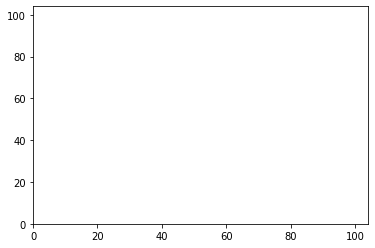

In [405]:
fig = plt.figure()
camera = Camera(fig)
for i in tqdm(range(200)):
    plt.pcolor(stored_maps[i])
    camera.snap()
animation = camera.animate()
animation.save('sim_final_1.mp4')

In [ ]:
1+2

In [404]:
from tqdm import tqdm